# I. Install and import libraries

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [2]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn. preprocessing import MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib. dates as mandates

from sklearn import linear_model
from keras. models import Sequential
from keras. layers import Dense
import keras. backend as K
from keras. callbacks import EarlyStopping
from keras. optimizers import Adam
from keras. models import load_model
from keras. layers import LSTM
from keras.utils import plot_model

import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

# II. Prepare data

## 1. Download & Read data

In [3]:
!git clone https://github.com/ntt2125/Finpros.git

Cloning into 'Finpros'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 8 (delta 1), pack-reused 0
Receiving objects: 100% (12/12), 3.05 MiB | 4.80 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
data_name='MSN'
data_path = f'/content/Finpros/data/{data_name}.csv'

df = pd.read_csv(data_path, na_values=['null'], index_col='Date/Time', parse_dates=True, infer_datetime_format=True)
df.head(10)

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2017-12-25 09:15:00,MSN,73.1,73.1,73.1,73.1,4210,0
2017-12-25 09:16:00,MSN,73.0,73.0,73.0,73.0,5000,0
2017-12-25 09:18:00,MSN,73.5,73.5,73.5,73.5,210,0
2017-12-25 09:20:00,MSN,73.2,73.5,73.1,73.1,2050,0
2017-12-25 09:21:00,MSN,73.0,73.0,73.0,73.0,1380,0
2017-12-25 09:22:00,MSN,73.0,73.1,73.0,73.1,1600,0
2017-12-25 09:23:00,MSN,73.1,73.1,73.1,73.1,910,0
2017-12-25 09:27:00,MSN,73.3,73.3,73.3,73.3,120,0
2017-12-25 09:30:00,MSN,73.5,73.5,73.5,73.5,520,0


In [5]:
# Checking null val
print(f"Dataframe shape: {df.shape}")
print('Null value present: ', df.isnull().values.any())

Dataframe shape: (135354, 7)
Null value present:  False


<Axes: xlabel='Date/Time'>

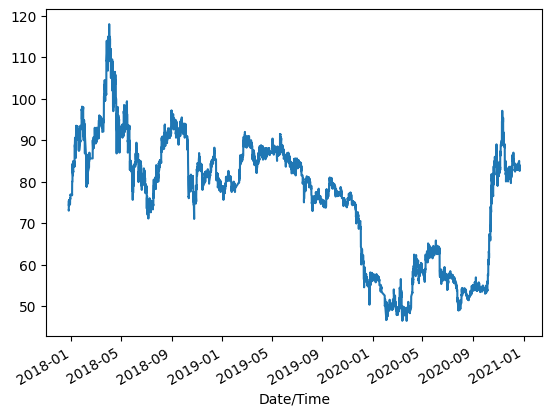

In [6]:
df['Close'].plot()

## 2. Setting target and select feature

In [7]:
# Set Target Variable
output_var = pd.DataFrame(df['Close'])

# Select the features
features = ['Open', 'High', 'Low', 'Volume']


## 3. Scaling

In [8]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head(10)

,Open,High,Low,Volume
Date/Time,,,,
2017-12-25 09:15:00,0.373072,0.372028,0.374474,0.001272
2017-12-25 09:16:00,0.371669,0.370629,0.373072,0.001512
2017-12-25 09:18:00,0.378682,0.377622,0.380084,0.000061
2017-12-25 09:20:00,0.374474,0.377622,0.374474,0.000618
2017-12-25 09:21:00,0.371669,0.370629,0.373072,0.000415
2017-12-25 09:22:00,0.371669,0.372028,0.373072,0.000482
2017-12-25 09:23:00,0.373072,0.372028,0.374474,0.000273
2017-12-25 09:27:00,0.375877,0.374825,0.377279,0.000033
2017-12-25 09:30:00,0.378682,0.377622,0.380084,0.000155


## 4. Split data to train, val, test

In [9]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## 5. Data Processing

In [10]:
train_X = np.array(X_train)
test_X = np.array(X_test)
X_train = train_X.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = test_X.reshape(X_test.shape[0], 1, X_test.shape[1])


In [11]:
print(X_train.shape)
print(X_test.shape)

(123050, 1, 4)
(12304, 1, 4)


# III. Config

In [12]:
!wandb login
# 4fd3a87393d5814c8c017631bd62012229e273e1

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
config = {
    'epochs': 200,
    'batch_size': 256,
    'activation': 'relu',
    'loss': 'mean_squared_error',
    'optimizer': 'adam',
    'metics': ['mape']
}

wandb.init(
    project='Finpros',
    name=f'model LSTM on stock data {data_name}.csv',
    config=config,

)

wandb: Currently logged in as: nguyentienthong2125. Use `wandb login --relogin` to force relogin


# III. Buil model


In [14]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, train_X.shape[1]), activation=config['activation'], return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=config['metics'])



In [15]:
test_X.shape[1]

4

## IV. Training

In [16]:
history=lstm.fit(X_train, y_train,
                 validation_data=(X_test, y_test),
                 epochs=config['epochs'],
                 batch_size=config['batch_size'],
                 verbose=1,
                 shuffle=False,
                 callbacks=[WandbMetricsLogger()])
wandb.finish()

Epoch 1/200
481/481 [==============================] - 5s 6ms/step - loss: 5516.1763 - mape: 96.9018 - val_loss: 5073.9507 - val_mape: 88.3626
Epoch 2/200
481/481 [==============================] - 2s 4ms/step - loss: 2406.1501 - mape: 61.4420 - val_loss: 666.2842 - val_mape: 32.7761
Epoch 3/200
481/481 [==============================] - 2s 4ms/step - loss: 215.0311 - mape: 19.9182 - val_loss: 36.8042 - val_mape: 7.0451
Epoch 4/200
481/481 [==============================] - 2s 4ms/step - loss: 61.3451 - mape: 9.8733 - val_loss: 82.2972 - val_mape: 10.6237
Epoch 5/200
481/481 [==============================] - 2s 4ms/step - loss: 52.0491 - mape: 8.6399 - val_loss: 80.7543 - val_mape: 10.4147
Epoch 6/200
481/481 [==============================] - 2s 4ms/step - loss: 36.3792 - mape: 7.0147 - val_loss: 71.7556 - val_mape: 9.7360
Epoch 7/200
481/481 [==============================] - 2s 5ms/step - loss: 23.8689 - mape: 5.4890 - val_loss: 59.4534 - val_mape: 8.8098
Epoch 8/200
481/481 [=====

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mape,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mape,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,199
epoch/learning_rate,0.001
epoch/loss,0.012
epoch/mape,0.0829
epoch/val_loss,0.07154


#V. Prediction


In [17]:
y_pred= lstm.predict(X_test)

385/385 [==============================] - 1s 2ms/step


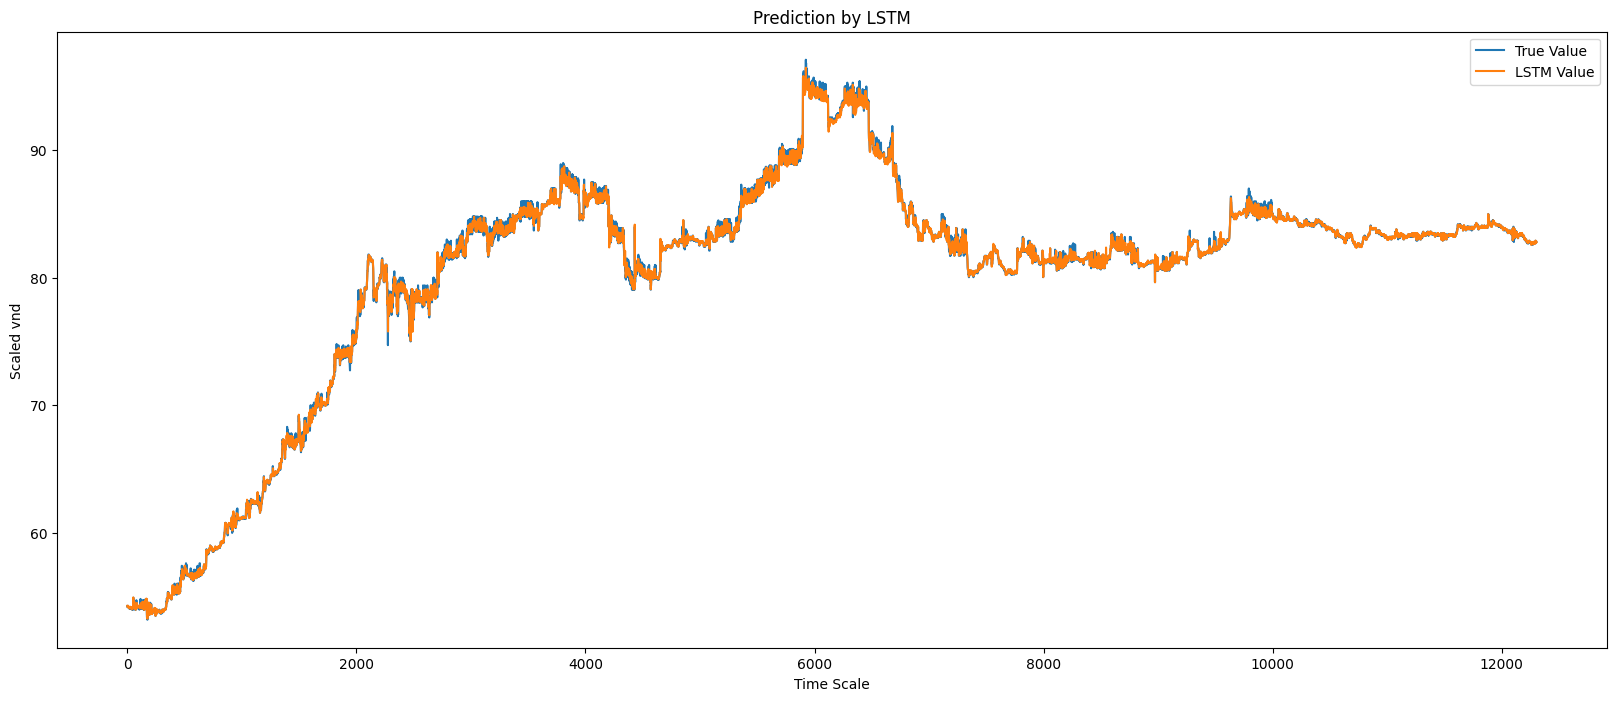

In [18]:
plt.figure(figsize=(20,8))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled vnd')
plt.legend()
plt.show()